In [1]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import urllib.request

np.random.seed(13)

#pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'numpy'

In [2]:
datasets_csv = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_name = [i[:-4].replace("-", "_") for i in datasets_csv]

root_URL = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets/"
remote_url = ["".join([root_URL, i]) for i in datasets_csv]

In [3]:
try :
    if os.getcwd().split("\\")[-1] != 'ml-25m':
        os.chdir('data\ml-25m\\')
except :
    os.makedirs("data/ml-25m")
    os.chdir('data\ml-25m\\')

In [10]:
for i in range(len(datasets_csv)):
    try :
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(datasets_csv[i])
    except :
        file = urllib.request.urlretrieve(remote_url[i], datasets_csv[i])
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(file[0])

In [11]:
mlb = MultiLabelBinarizer(sparse_output=True)
df_movies = df_movies.join(pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))
df_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_genome = pd.merge(df_genome_tags, df_genome_scores, on="tagId")
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df = pd.merge(df_movies, df_genome, on="movieId")

In [13]:
df_genome = pd.merge(df_genome_tags, df_genome_scores, on="tagId")
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df = pd.merge(df_movies, df_genome, on="movieId")

In [14]:
df_ratings = df_ratings.iloc[:,[1,2]]
df_ratings = df_ratings.groupby(by='movieId').mean()
df = pd.merge(df_ratings, df, on="movieId")

In [15]:
df_X = df.loc[:,df.columns != 'rating']
df_Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=20)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=20)

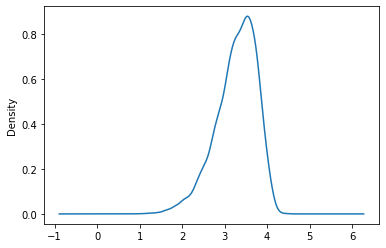

In [16]:
# PRE DATA VISUALIZATION
df_Y.plot(kind ='density')
plt.show()

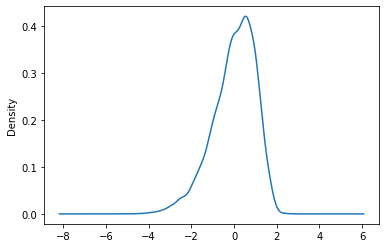

In [17]:
# NORMALIZATION
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
Y_train.plot(kind ='density')
plt.show()